In [31]:
import pandas as pd
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [25]:
# Load the preprocessed dataset
event_df = pd.read_csv("/Users/armaansidhu/Documents/Uni/year-2/EODP/code/proj_2/code/event_df.csv")

# Fill missing values
event_df['DEG_URBAN_NAME'] = event_df['DEG_URBAN_NAME'].fillna('Unknown')
event_df['ROAD_TYPE'] = event_df['ROAD_TYPE'].fillna('Unknown')

# Map coded values to names
node_type_from_id = {"I": "Intersection", "N": "Non-Intersection", "O": "Off Road", "U": "Unknown"}
light_condition_from_id = {
    1: "Day", 2: "Dusk/dawn", 3: "Dark street lights on", 4: "Dark street lights off",
    5: "Dark no street lights", 6: "Dark street lights unknown", 9: "Unknown"
}
road_geometry_from_id = {
    1: "Cross intersection", 2: "T Intersection", 3: "Y Intersection", 4: "Multiple intersections",
    5: "Not at intersection", 6: "Dead end", 7: "Road closure", 8: "Private property", 9: "Unknown"
}

event_df["NODE_TYPE"] = event_df["NODE_TYPE"].map(node_type_from_id)
event_df["LIGHT_CONDITION"] = event_df["LIGHT_CONDITION"].map(light_condition_from_id)
event_df["ROAD_GEOMETRY"] = event_df["ROAD_GEOMETRY"].map(road_geometry_from_id)

# Bin time of day
def bin_time_of_day(time_str):
    hour = int(time_str.split(':')[0])
    if 0 <= hour < 6:
        return "Late_Night"
    elif 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    else:
        return "Evening"

event_df["TIME_BIN"] = event_df["ACCIDENT_TIME"].apply(bin_time_of_day)

# Drop unnecessary columns
event_df.drop(columns=["ACCIDENT_NO", "ACCIDENT_TIME", "POSTCODE_CRASH"], inplace=True)

# One-hot encode categorical columns
one_hot_cols = ["NODE_TYPE", "DEG_URBAN_NAME", "ROAD_TYPE", "LIGHT_CONDITION", "ROAD_GEOMETRY", "TIME_BIN"]
event_df_encoded = pd.get_dummies(event_df, columns=one_hot_cols)

# Handle list columns (ATMOSPH_COND, SURFACE_COND)
event_df_encoded["ATMOSPH_COND"] = event_df_encoded["ATMOSPH_COND"].apply(eval)
event_df_encoded["SURFACE_COND"] = event_df_encoded["SURFACE_COND"].apply(eval)

unique_atmosph = sorted({val for sublist in event_df_encoded["ATMOSPH_COND"] for val in sublist})
unique_surface = sorted({val for sublist in event_df_encoded["SURFACE_COND"] for val in sublist})

for val in unique_atmosph:
    event_df_encoded[f"ATMOSPH_COND_{val}"] = event_df_encoded["ATMOSPH_COND"].apply(lambda x: int(val in x))
for val in unique_surface:
    event_df_encoded[f"SURFACE_COND_{val}"] = event_df_encoded["SURFACE_COND"].apply(lambda x: int(val in x))

event_df_encoded.drop(columns=["ATMOSPH_COND", "SURFACE_COND"], inplace=True)

# Separate features and label
X = event_df_encoded.drop(columns=["SEVERITY"])
y = event_df_encoded["SEVERITY"]

#4 removed due to low sample size which would make for a bad machine learning model
X = X[y != 4]
y = y[y != 4]

# Combine for easier sampling
df_balanced = pd.concat([X, y], axis=1)

# Group by severity and undersample each group
min_count = df_balanced['SEVERITY'].value_counts().min()
df_grouped = (
    df_balanced.groupby('SEVERITY', group_keys=False)
    .apply(lambda x: x.sample(min_count, random_state=42))
    .sample(frac=1, random_state=42)
)

# Final balanced X and y
X_balanced = X
y_balanced = y 

# Display class counts
print(y_balanced.value_counts())

SEVERITY
3    111326
2     64334
1      2944
Name: count, dtype: int64


/var/folders/v6/vx20krk11bv5lhqpv4ptz4n40000gn/T/ipykernel_54088/3606018893.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, random_state=42))


In [26]:
scaler = StandardScaler()
X_bal_scaled = scaler.fit_transform(X_balanced)

pca = PCA(n_components=0.95) 
X_pca = pca.fit_transform(X_bal_scaled)

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)
X_train_split, X_validation, y_train_split, y_validation = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

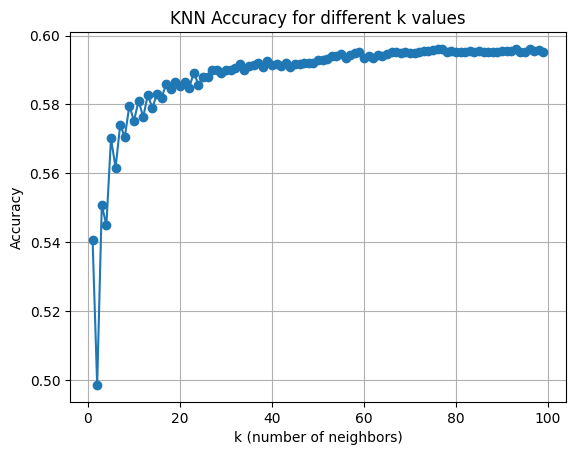

Best k: 93


In [27]:
k_values = range(1, 100)
accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k, weights='distance')
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_validation)
    accuracies.append(accuracy_score(y_validation, y_pred))


# Plot
import matplotlib.pyplot as plt
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k (number of neighbors)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for different k values')
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
print("Best k:", best_k)

Precision: [0.03333333 0.42745849 0.64743797]
Recall: [0.00679117 0.26012279 0.80754547]
F1 Score: [0.0112835  0.32342852 0.71868255]
Accuracy 0.5971557347218723


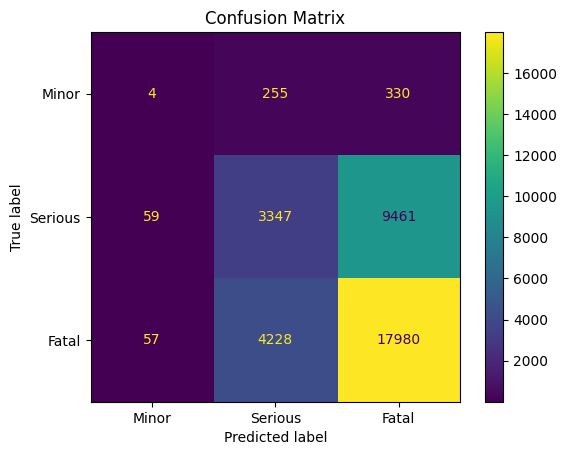

Macro F1: 0.35113152088648536
Micro F1: 0.5971557347218723
Weighted F1: 0.5646445408059524
Cross-validated F1 (macro): 0.3502708435980131


In [28]:
knn = KNeighborsClassifier(n_neighbors=93, weights='distance')  # You can tune this later
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

accuracy = knn.score(X_test, y_test)
print('Accuracy', accuracy)

cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Minor", "Serious", "Fatal"])

disp.plot()

plt.title("Confusion Matrix")
plt.show()

print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("Micro F1:", f1_score(y_test, y_pred, average='micro'))
print("Weighted F1:", f1_score(y_test, y_pred, average='weighted'))

scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1_macro')
print("Cross-validated F1 (macro):", scores.mean())

TRAINING WITH UNDERSAMPLING

In [20]:
# Group by severity and undersample each group
min_count = df_balanced['SEVERITY'].value_counts().min()
df_grouped = (
    df_balanced.groupby('SEVERITY', group_keys=False)
    .apply(lambda x: x.sample(min_count, random_state=42))
    .sample(frac=1, random_state=42)
)

# Final balanced X and y
X_balanced = df_grouped.drop(columns=["SEVERITY"])
y_balanced = df_grouped["SEVERITY"]

# Display class counts
print(y_balanced.value_counts())

SEVERITY
3    2944
1    2944
2    2944
Name: count, dtype: int64


/var/folders/v6/vx20krk11bv5lhqpv4ptz4n40000gn/T/ipykernel_54088/3239522629.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, random_state=42))


In [21]:
scaler = StandardScaler()
X_bal_scaled = scaler.fit_transform(X_balanced)

pca = PCA(n_components=0.95) 
X_pca = pca.fit_transform(X_bal_scaled)

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)
X_train_split, X_validation, y_train_split, y_validation = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

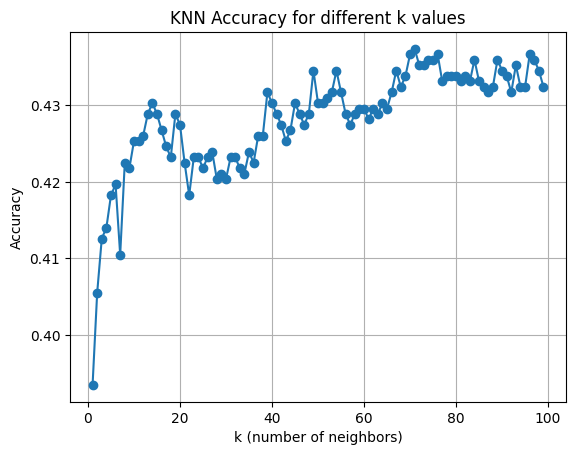

Best k: 71


In [22]:
k_values = range(1, 100)
accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k, weights='distance')
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_validation)
    accuracies.append(accuracy_score(y_validation, y_pred))


# Plot
import matplotlib.pyplot as plt
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k (number of neighbors)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for different k values')
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
print("Best k:", best_k)

Precision: [0.49050633 0.36311787 0.45812808]
Recall: [0.52631579 0.32427844 0.47368421]
F1 Score: [0.50778051 0.3426009  0.46577629]
Accuracy 0.44142614601018676


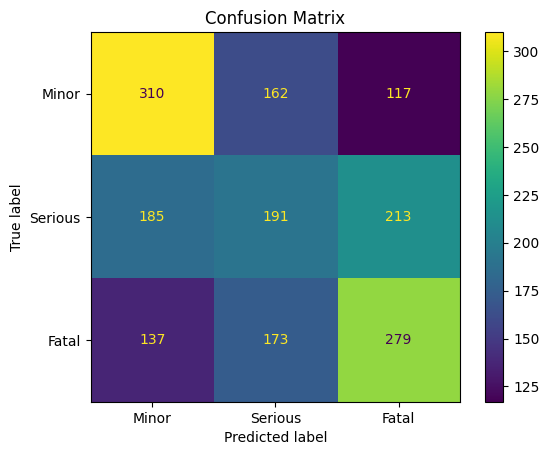

Macro F1: 0.438719232821511
Micro F1: 0.44142614601018676
Weighted F1: 0.43871923282151093
Cross-validated F1 (macro): 0.4478592645639671


In [23]:
knn = KNeighborsClassifier(n_neighbors=71, weights='distance')  # You can tune this later
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

accuracy = knn.score(X_test, y_test)
print('Accuracy', accuracy)

cm = confusion_matrix(y_test, y_pred, labels=[1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Minor", "Serious", "Fatal"])

disp.plot()

plt.title("Confusion Matrix")
plt.show()

print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("Micro F1:", f1_score(y_test, y_pred, average='micro'))
print("Weighted F1:", f1_score(y_test, y_pred, average='weighted'))

scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1_macro')
print("Cross-validated F1 (macro):", scores.mean())

DESICION TREE Without Undersampling

In [45]:
X_train_tree, X_test_tree, y_train_tree, y_test_tree= train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [46]:
clf = DecisionTreeClassifier(max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42)
clf.fit(X_train_tree, y_train_tree)
y_pred_tree = clf.predict(X_test_tree)

Accuracy: 0.6259903138210017

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00       589
           2       0.48      0.17      0.26     12867
           1       0.65      0.90      0.75     22265

    accuracy                           0.63     35721
   macro avg       0.38      0.36      0.34     35721
weighted avg       0.58      0.63      0.56     35721



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

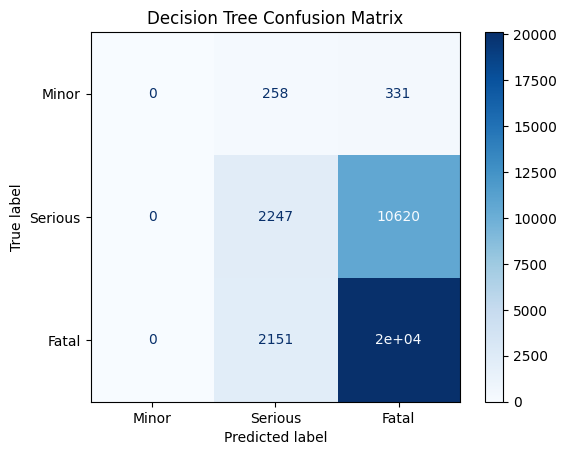

Cross-validated F1 (macro): 0.45071680428696836


In [51]:
accuracy = accuracy_score(y_test_tree, y_pred_tree)
target_names = [str(i) for i in y.unique()]  # Dynamic target names to handle all classes
report = classification_report(y_test_tree, y_pred_tree, target_names = target_names)

# Output
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

cm_tree = confusion_matrix(y_test_tree, y_pred_tree, labels=[1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=["Minor", "Serious", "Fatal"])

# Plot
disp.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree Confusion Matrix")
plt.show()

scores_tree = cross_val_score(clf, X_train_tree, y_train_tree, cv=5, scoring='f1_macro')
print("Cross-validated F1 (macro):", scores.mean())

DECISION TREE with undersampling

In [48]:
df_balanced = pd.concat([X, y], axis=1)

# Group by severity and undersample each group
min_count = df_balanced['SEVERITY'].value_counts().min()
df_grouped = (
    df_balanced.groupby('SEVERITY', group_keys=False)
    .apply(lambda x: x.sample(min_count, random_state=42))
    .sample(frac=1, random_state=42)
)

# Final balanced X and y
X_balanced_tree = df_grouped.drop(columns=["SEVERITY"])
y_balanced_tree = df_grouped["SEVERITY"]

X_train_tree_sample, X_test_tree_sample, y_train_tree_sample, y_test_tree_sample= train_test_split(
    X_balanced_tree, y_balanced_tree, test_size=0.2, stratify=y_balanced_tree, random_state=42
)

/var/folders/v6/vx20krk11bv5lhqpv4ptz4n40000gn/T/ipykernel_54088/3501486541.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, random_state=42))


In [49]:
clf_sampled = DecisionTreeClassifier(max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42)
clf.fit(X_train_tree_sample, y_train_tree_sample)
y_pred_tree_sample = clf.predict(X_test_tree_sample)

Accuracy: 0.4595359366157329

Classification Report:
               precision    recall  f1-score   support

           3       0.55      0.55      0.55       589
           2       0.36      0.22      0.27       589
           1       0.44      0.61      0.51       589

    accuracy                           0.46      1767
   macro avg       0.45      0.46      0.44      1767
weighted avg       0.45      0.46      0.44      1767



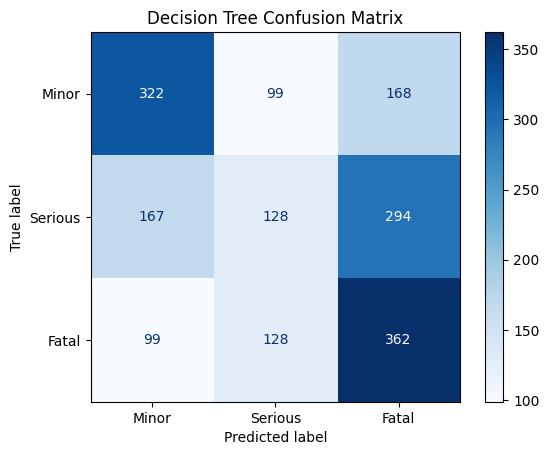

Cross-validated F1 (macro): 0.4421823311690016


In [52]:
accuracy = accuracy_score(y_test_tree_sample, y_pred_tree_sample)
target_names = [str(i) for i in y.unique()]  # Dynamic target names to handle all classes
report = classification_report(y_test_tree_sample, y_pred_tree_sample, target_names = target_names)

# Output
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

cm_tree = confusion_matrix(y_test_tree_sample, y_pred_tree_sample, labels=[1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=["Minor", "Serious", "Fatal"])

# Plot
disp.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree Confusion Matrix")
plt.show()

scores_tree_sample = cross_val_score(clf_sampled, X_train_tree_sample, y_train_tree_sample, cv=5, scoring='f1_macro')
print("Cross-validated F1 (macro):", scores_tree_sample.mean())